# Inference with the Registration Model
This notebook contains the steps for using the pre-trained registraion model only to track the myocardium motion. Different with the LaMoD code that only requires the registration encoder, to run this code you need to have [lagomorph](https://github.com/jacobhinkle/lagomorph) installed and run it on a machine with (Nvidia) GPU. Also, please refer to [this guide](../appendix/Modiy-Lagomorph.md) to manually update Lagomorph if you meet the error that `torch.irfft` is expired.

Note that due to the data accessibility limit, we cannot offer any example data here. However you can check the data structure shown in the notebook and insert your data here. The key is that the input should be a PyTorch tensor with shape `[1, n_frames, H, W]`, where `n_frames` is the number of sequence frames. `H` and `W` are the frame height and width, respectively.

In [1]:
%load_ext autoreload
%autoreload 2
# %cd /p/mmcardiac/Jerry/code/CINE-DENSE-Translation
%cd ..
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from modules.data import check_dict

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [2]:
# USE GPU 0
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. Load Data
Note that due to the data accessibility limit, we cannot offer any example data here. However you can check the data structure shown in the notebook and insert your data here. The key is that the input should be a PyTorch tensor with shape `[1, n_frames, H, W]`, where `n_frames` is the number of sequence frames. `H` and `W` are the frame height and width, respectively.

In [3]:
test_fname = '/scratch/jx8fh/2024-06-22-MICCAI-ShapeMI-Workshop-data/lamod_test.npy'
test_data = np.load(test_fname, allow_pickle=True).tolist()

In [4]:
check_dict(test_data[0])

ori_n_frames                                                 51                  
augmented                                                    False               
DENSE_slice_mat_filename                                     /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/033_S01_base_auto.1_ROI.1.mat
DENSE_slice_location                                         76.947609505431     
subject_id                                                   033-DENSE           
slice_idx                                                    31                  
slice_full_id                                                033-31              
full_name                                                    033-DENSE_31        
DENSE_disp                                                   (2, 40, 48, 48)     
myo_masks                                                    (1, 40, 128, 128)   


# 2. Load Config

In [17]:
import json
config_fname = 'configs/ours-inference-registration.json'
config = json.load(open(config_fname))

# 3. Build Model

In [28]:
# from models.LaMoD import LaMoD
# network = LaMoD(config['networks'], device).to(device)

from models.registration.regnet import RegNet
model = RegNet(config['networks']['registration'])

pretrained_model_path = config['networks']['registration']['pretrained_model_path']
model.load_state_dict(
        torch.load(pretrained_model_path, map_location=device), 
        strict=True)
model = model.to(device)

Skip connect: False


# 4. Inference

In [21]:
test_data[0]['myo_masks'].shape

(1, 40, 128, 128)

In [43]:
check_data_idx = 0

# Prepare Pytorch tensor
inference_input_data = test_data[check_data_idx]['myo_masks']
inference_input_video      = torch.from_numpy(inference_input_data).to(device, torch.float)
inference_input_video_ori_frame = test_data[check_data_idx]['ori_n_frames']
inference_output_dict = model.inference_2D_video(
    inference_input_video)



In [44]:
# check the return values
check_dict(inference_output_dict)

velocity                                                     torch.Size([1, 2, 39, 128, 128])
momentum                                                     torch.Size([1, 2, 39, 128, 128])
displacement_T_S                                             torch.Size([1, 2, 39, 128, 128])
displacement                                                 torch.Size([1, 2, 39, 128, 128])
deformed_source                                              torch.Size([1, 1, 39, 128, 128])
latent                                                       torch.Size([1, 16, 39, 16, 16])


Text(0.5, 1.0, 'Predicted Displacement Field (subsampled)')

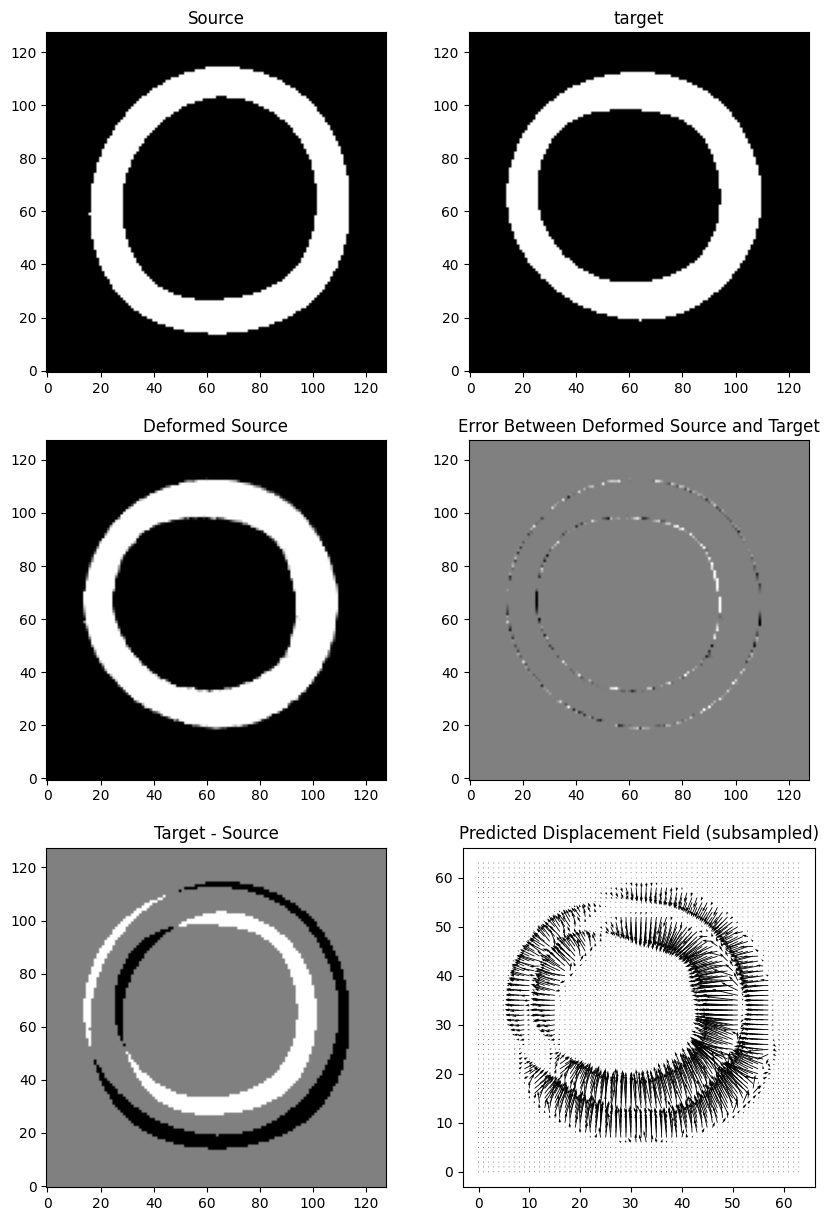

In [50]:
# Extract prediction and visualize
inference_disp = inference_output_dict['displacement'].detach().cpu()
inference_defromed_image = inference_output_dict['deformed_source'].detach().cpu()

check_frame_idx = 20
soruce_frame = inference_input_data[0,0]
deformed_soruce_frame = inference_defromed_image[0,0,check_frame_idx]
target_frame = inference_input_data[0,check_frame_idx]
fig, axs = plt.subplots(3, 2, figsize=(10,15))
# Source frame
axs[0,0].imshow(soruce_frame, cmap='gray')
axs[0,0].set_title("Source")
axs[0,0].invert_yaxis()
# Target frame
axs[0,1].imshow(target_frame, cmap='gray')
axs[0,1].set_title("target")
axs[0,1].invert_yaxis()
# Deformed Image
axs[1,0].imshow(deformed_soruce_frame, cmap='gray')
axs[1,0].set_title("Deformed Source")
axs[1,0].invert_yaxis()
# Error between deformed source and target
axs[1,1].imshow(deformed_soruce_frame - target_frame, cmap='gray')
axs[1,1].set_title("Error Between Deformed Source and Target")
axs[1,1].invert_yaxis()
# The Difference between soruce and target
axs[2,0].imshow(target_frame - soruce_frame, cmap='gray')
axs[2,0].set_title("Target - Source")
axs[2,0].invert_yaxis()

# Predicted displacement field
# subsampled to show the arrows clearly
axs[2,1].quiver(
    inference_disp[0,0,check_frame_idx][::2,::2],
    inference_disp[0,1,check_frame_idx][::2,::2],
    units='xy',
    scale=1
)
axs[2,1].set_title("Predicted Displacement Field (subsampled)")